In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colormaps

class Body:

    def __init__(self, mass, position, velocity):
        self.mass = np.float64(mass) # mass of body [kg]
        self.position = np.array(position, dtype=np.float64) # position of body [m]
        self.velocity = np.array(velocity, dtype=np.float64) # velocity of body [m/s]

# initialize bodies with random masses, positions, and velocities over set range
# num_bodies [scalar], mass_range [low, high], position_range [low, high], velocity_range [low, high]
def initialize_bodies(num_bodies, mass_range, position_range, velocity_range):

    masses = np.random.uniform(mass_range[0], mass_range[1], num_bodies)
    positions = np.random.uniform(position_range[0], position_range[1], (num_bodies, 2))
    velocities = np.random.uniform(velocity_range[0], velocity_range[1], (num_bodies, 2))

    # returning list of bodies
    return [Body(masses[i], positions[i], velocities[i]) for i in range(num_bodies)]


def calculate_force(bodies):

    G = 1 # gravitational constant
    soft = 0.05 # softening parameter

    F = np.zeros((len(bodies), 2)) # initialize net force array

    for i, body_i in enumerate(bodies):
        for j in range(i + 1, len(bodies)): # avoid redundant force calculations
                # displacement vector from body_i to body_j
                r_ji = bodies[j].position - bodies[i].position 
                # force vector on body_i from body_j
                F_ij = (G * bodies[i].mass * bodies[j].mass * r_ji) / ((np.linalg.norm(r_ji) + soft)**3)
                F[i] += F_ij # calculate net force on body_i
                F[j] -= F_ij # calculate net force on body_j
    
    return F # return net force array

In [24]:
def energy_cons(bodies):

    G = 1
    soft = 0.05

    kinetic_energy = 0
    potential_energy = 0 
    total_energy = 0
    
    for i, body_i in enumerate(bodies):
        kinetic_energy += 0.5 * bodies[i].mass * (np.linalg.norm(bodies[i].velocity) ** 2)
        for j in range(i + 1, len(bodies)): # avoid redundant force calculations
                # displacement vector from body_i to body_j
                r_ij = bodies[j].position - bodies[i].position 
                # Updating total Potential Energy 
                potential_energy += -(G * bodies[i].mass * bodies[j].mass) / (np.linalg.norm(r_ij))
        # Calculating total energy of the system
        total_energy = potential_energy + kinetic_energy

    return total_energy

def momentum_cons(bodies):

    momentum = 0

    for i, body_i in enumerate(bodies):
        momentum += bodies[i].mass * (bodies[i].velocity)

    return(np.linalg.norm(momentum))

In [25]:
# initialize bodies with random masses, positions, and velocities over set range
# bodies[n] = Body(mass, position [x, y], velocity [vx, vy])
#bodies = initialize_bodies(3, mass_range = [0.1, 3], position_range = [-15, 15], velocity_range = [-0.5, 0.5])

# using dimensionless units in terms of solar masses, AU

# solar system
bodies = [
    Body(mass = 1, position=[0, 0], velocity=[0, 0]), # sun
    Body(mass = 3.00e-6, position=[1, 0], velocity=[0, 1]), # earth
    Body(mass = 3.21e-7, position=[1.5, 0], velocity=[0, np.sqrt(1/1.5)]), # mars
    Body(mass = 9.55e-4, position=[5.2, 0], velocity=[0, np.sqrt(1/5.2)]), # jupiter
    Body(mass = 2.86e-4, position=[9.5, 0], velocity=[0, np.sqrt(1/9.5)]), # saturn
    Body(mass = 4.36e-5, position=[19.2, 0], velocity=[0, np.sqrt(1/19.2)]), # uranus
    Body(mass = 5.15e-5, position=[30.1, 0], velocity=[0, np.sqrt(1/30.1)]) # neptune
]

# binary star system
'''bodies = [
    Body(mass = 2, position = [0, 10], velocity = [-0.1, 0]), # star_1
    Body(mass = 1, position = [0, -10], velocity = [0.1, 0]) # star_2
]'''

'bodies = [\n    Body(mass = 2, position = [0, 10], velocity = [-0.1, 0]), # star_1\n    Body(mass = 1, position = [0, -10], velocity = [0.1, 0]) # star_2\n]'

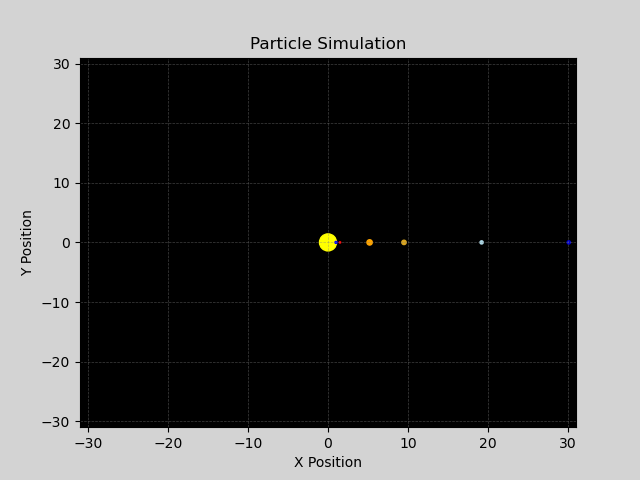

In [26]:
# Animation using matplotlib

%matplotlib widget

# Time step for position updates
dt = 0.1

# Set up the plot
fig, ax = plt.subplots()
ax.set_xlim(-31, 31) # X-axis limits
ax.set_ylim(-31, 31) # Y-axis limits
ax.set_title("Particle Simulation", color="black")  # Title
ax.set_xlabel("X Position", color="black")  # X-axis label
ax.set_ylabel("Y Position", color="black")  # Y-axis label
ax.tick_params(axis='x', colors="black")  # X-axis ticks
ax.tick_params(axis='y', colors="black")  # Y-axis ticks
ax.set_facecolor("black")  # Set background color
fig.patch.set_facecolor("lightgray")  # Outside the plot
ax.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.5)

#cmap = colormaps["tab20"].resampled(len(bodies))  # Dynamically resample colormap
#colors = [cmap(i) for i in range(len(bodies))] # Create list of colors
colors = ['yellow', 'blue', 'red', 'orange', 'goldenrod', 'lightblue', 'mediumblue'] # planet colors

# Create scatter plot with initial positions
scat = ax.scatter(
    [body.position[0] for body in bodies], # Initial x-coordinate of bodies
    [body.position[1] for body in bodies], # Initial y-coordinate of bodies
    s = [150*(body.mass)**(1/3) for body in bodies], # Size of bodies proportional to mass
    c = colors,  # Color of bodies
)

# Energy and Momentum Tracking
energies = []
momenta = []

# Update function for animation
def update_position(frame):

    for n, body in enumerate(bodies):

        F = calculate_force(bodies) # calculate net force on bodies

        # Leapfrog method
        body.velocity += 0.5 * F[n] / body.mass * dt # Update velocity (half step)
        body.position += body.velocity * dt # Update position (full step)
        F = calculate_force(bodies) # Recalculate force
        body.velocity += 0.5 * F[n] / body.mass * dt # Update velocity (second half step)
        positions = [body.position for body in bodies] # Create array of positions to update scatter plot

    # Record energy and momentum for each frame
    energies.append(energy_cons(bodies))
    momenta.append(momentum_cons(bodies))
        
    scat.set_offsets(positions)  # Update scatter plot
  
    return scat


# Create the animation
ani = animation.FuncAnimation(
    fig=fig,
    func=update_position,
    frames=range(10000),  # Number of frames
    interval=1,  # Time between frames in milliseconds
    repeat=False,  # Stop after the last frame
)

#ani.save('particle_simulation.mp4', writer='ffmpeg', fps=30) # Save animation as .mp4

# Show the plot
plt.show()

Text(0, 0.5, 'Energy')

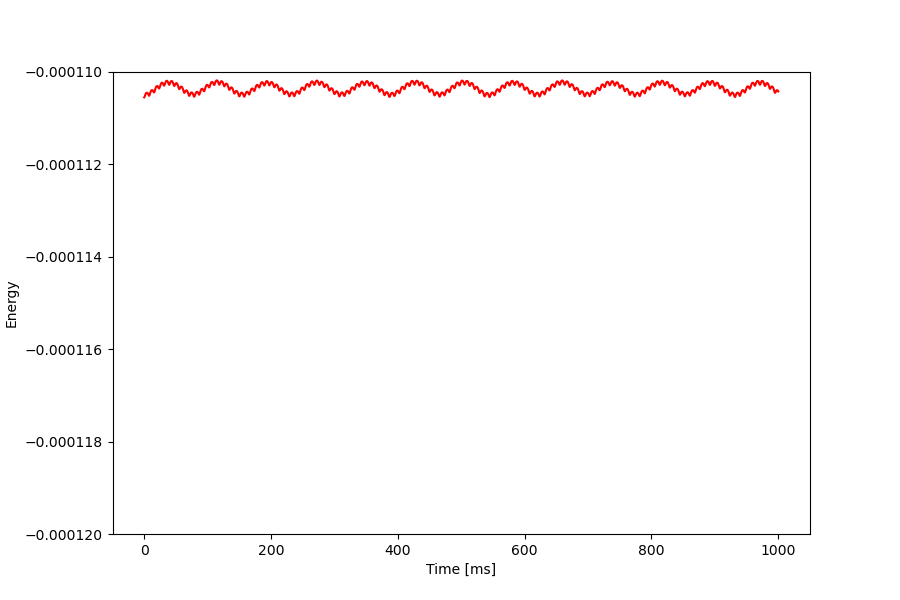

In [27]:
fig,ax = plt.subplots(figsize = (9,6))

# Energy and momentum tracking
timesteps = np.arange(0, 1000.1, dt) 


# Plotting total energy with timesteps
ax.plot(timesteps, energies, label = "Total Energy", color = "red")
ax.set_ylim(-0.00012, -0.00011)
ax.set_xlabel("Time [ms]", color="black")  
ax.set_ylabel("Energy", color="black")  

Text(0, 0.5, 'Momentum')

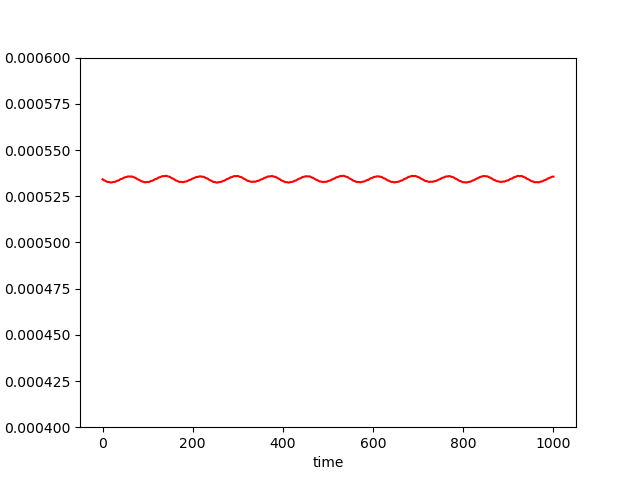

In [33]:
# Plotting total momentum with timesteps
fig,ax = plt.subplots()
ax.plot(timesteps, momenta, label = "Total Momentum", color = "red")
ax.set_ylim(0.0004, 0.0006)
ax.set_xlabel("time", color="black")  
ax.set_ylabel("Momentum", color="black")  